In [1429]:
!pip install optuna

In [1430]:
# EDA for
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold
import gc

# Metrics
from sklearn.metrics import (
    mean_squared_error
)

from tensorflow.keras.metrics import RootMeanSquaredError

# Models

import keras_tuner
from keras import *
from scikeras.wrappers import KerasRegressor
from keras import Sequential
from keras.layers import (
    Dense, 
    Dropout,
)

from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import (
    cross_val_score, 
    RepeatedKFold,
    train_test_split,
    GridSearchCV,
    KFold,
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from catboost import *

# Any
import warnings
warnings.filterwarnings('ignore')

In [1431]:
class CFG:
    TARGET = 'nivel_y'
    N_FOLDS = 20
    RANDOM_STATE = 87


    def dataset_6HZ() -> pd.DataFrame:
        TRAIN_PATH = './data/Stable/Day1/2024_09_02_6hz 19_09-20.csv'
        TRAIN_PATH_AIR = './data/Stable/Day1/2024_09_02_6hz 19_09-20_air.csv'

        TEST_PATH_6HZ = './test/Stable/Day1/2024_09_03_6hz 18_08-19_11.csv'
        TEST_PATH_AIR_6HZ = './test/Stable/Day1/2024_09_03_6hz 18_08-19_11_air.csv'

        train = pd.read_csv(TRAIN_PATH)[:4700].copy()
        train['air_temp'] = pd.read_csv(TRAIN_PATH_AIR)['temperature'][:4700]
        test = pd.read_csv(TEST_PATH_6HZ)[:5700].copy()
        test['air_temp'] = pd.read_csv(TEST_PATH_AIR_6HZ)['temperature'][:5700]

        return train, test
    

    def dataset_3HZ() -> pd.DataFrame:
        TRAIN_PATH_1 = './data/Stable/Day4/2024_09_02_3hz 10_14-11_58_1.csv'
        TRAIN_PATH_2 = './data/Stable/Day4/2024_09_02_3hz 10_14-11_58_2.csv'
        TRAIN_PATH_AIR_1 = './data/Stable/Day4/2024_09_02_3hz 10_14-11_58_2_air.csv'

        TEST_PATH_3HZ_1 = './test/Stable/Day4/2024_09_04_3hz 14_13-15_43_1.csv'
        TEST_PATH_3HZ_2 = './test/Stable/Day4/2024_09_04_3hz 14_13-15_43_2.csv'
        TEST_PATH_AIR_3HZ = './test/Stable/Day4/2024_09_04_3hz 14_13-15_43_air.csv'

        train = pd.concat([pd.read_csv(TRAIN_PATH_1),
                          pd.read_csv(TRAIN_PATH_2)],ignore_index=True)[:8000].copy()
        train['air_temp'] = pd.read_csv(TRAIN_PATH_AIR_1)['temperature'][:8000]
        test = pd.concat([pd.read_csv(TEST_PATH_3HZ_1),
                               pd.read_csv(TEST_PATH_3HZ_2)],ignore_index=True)[:4700].copy()
        test['air_temp'] = pd.read_csv(TEST_PATH_AIR_3HZ)['temperature'][:4700]

        return train, test
    

    def dataset_1HZ() -> pd.DataFrame:
        TRAIN_PATH_1 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_1.csv'
        TRAIN_PATH_AIR_1 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_1_air.csv'
        TRAIN_PATH_2 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_2.csv'
        TRAIN_PATH_AIR_2 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_2_air.csv'

        TEST_PATH_1HZ = './test/Stable/Day2/2024_09_03_1hz 16_01-17_35.csv'
        TEST_PATH_AIR_1HZ = './test/Stable/Day2/2024_09_03_1hz 16_01-17_35_air.csv'

        
        train_1 = pd.read_csv(TRAIN_PATH_1).copy()
        train_1['air_temp'] = pd.read_csv(TRAIN_PATH_AIR_1)['temperature']
        train_2 = pd.read_csv(TRAIN_PATH_2).copy()
        train_2['air_temp'] = pd.read_csv(TRAIN_PATH_AIR_2)['temperature']

        train = pd.concat([train_1,train_2],ignore_index=True)
        train = train[:5500]

        test = pd.read_csv(TEST_PATH_1HZ)[:3000].copy()
        test['air_temp'] = pd.read_csv(TEST_PATH_AIR_1HZ)['temperature'][:3000]

        return train, test


    def dataset_03HZ() -> pd.DataFrame:
        TRAIN_PATH = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01.csv'
        TRAIN_PATH_AIR_1 = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01_1_air.csv'
        TRAIN_PATH_AIR_2 = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01_2_air.csv'
        TRAIN_PATH_AIR_3 = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01_3_air.csv'

        TEST_PATH_03HZ = './test/Stable/Day3/2024_09_03_03hz 19_51-20_35.csv'
        TEST_PATH_AIR_03HZ = './test/Stable/Day3/2024_09_03_03hz 19_51-20_35_air.csv'

        temp = pd.concat([pd.read_csv(TRAIN_PATH_AIR_1),
                          pd.read_csv(TRAIN_PATH_AIR_2),
                          pd.read_csv(TRAIN_PATH_AIR_3)],ignore_index=True)

        train = pd.read_csv(TRAIN_PATH)[300:1000].copy()
        train['air_temp'] = temp['temperature'][300:1000]
        train = train.reset_index(drop=True)

        test = pd.read_csv(TEST_PATH_03HZ)[:1000].copy()
        test['air_temp'] = pd.read_csv(TEST_PATH_AIR_03HZ)['temperature'][:1000]

        return train, test

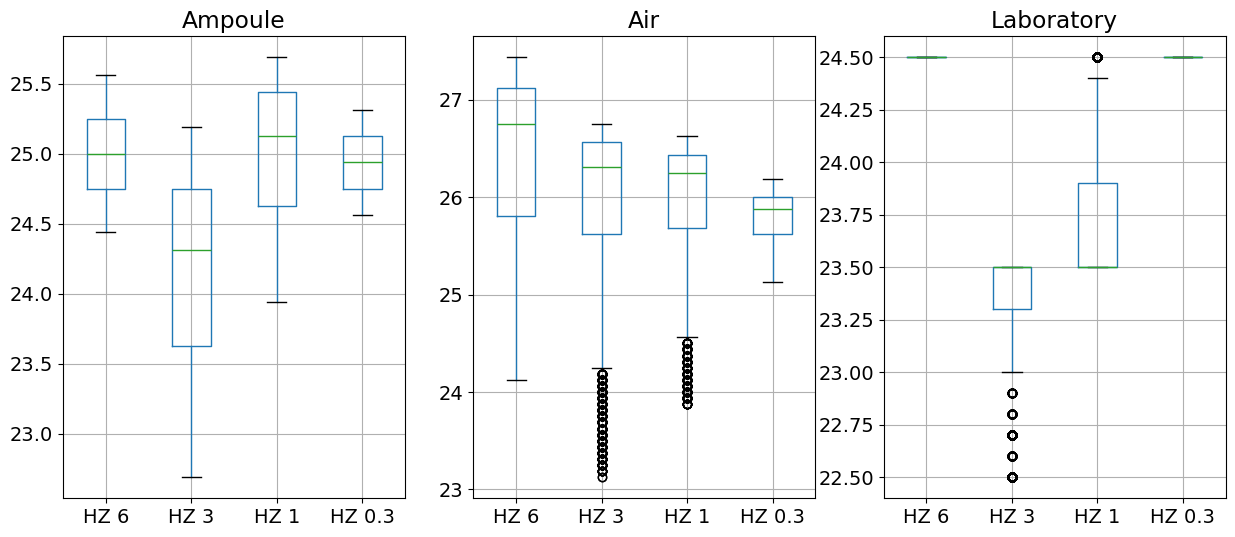

In [1432]:
HZ6, _ = CFG.dataset_6HZ()
HZ3, _ = CFG.dataset_3HZ()
HZ1, _ = CFG.dataset_1HZ()
HZ03, _ = CFG.dataset_03HZ()


temp = pd.DataFrame({'HZ 6' : HZ6['temperature'], 
        'HZ 3' : HZ3['temperature'], 
        'HZ 1' : HZ1['temperature'], 
        'HZ 0.3' : HZ03['temperature']})

air_temp = pd.DataFrame({'HZ 6' : HZ6['air_temp'], 
        'HZ 3' : HZ3['air_temp'], 
        'HZ 1' : HZ1['air_temp'], 
        'HZ 0.3' : HZ03['air_temp']})

nivel = pd.DataFrame({'HZ 6' : HZ6['nivel_t'], 
        'HZ 3' : HZ3['nivel_t'], 
        'HZ 1' : HZ1['nivel_t'], 
        'HZ 0.3' : HZ03['nivel_t']})

fig = plt.figure(figsize=(15,6))
ax1 =fig.add_subplot(1,3,1)
temp.boxplot(ax = ax1)
ax1.set_title('Ampoule')
ax2 =fig.add_subplot(1,3,2)
air_temp.boxplot(ax = ax2)
ax2.set_title('Air')
ax3 =fig.add_subplot(1,3,3)
nivel.boxplot(ax = ax3)
ax3.set_title('Laboratory')
plt.show()

In [1457]:
train, test = CFG.dataset_3HZ()

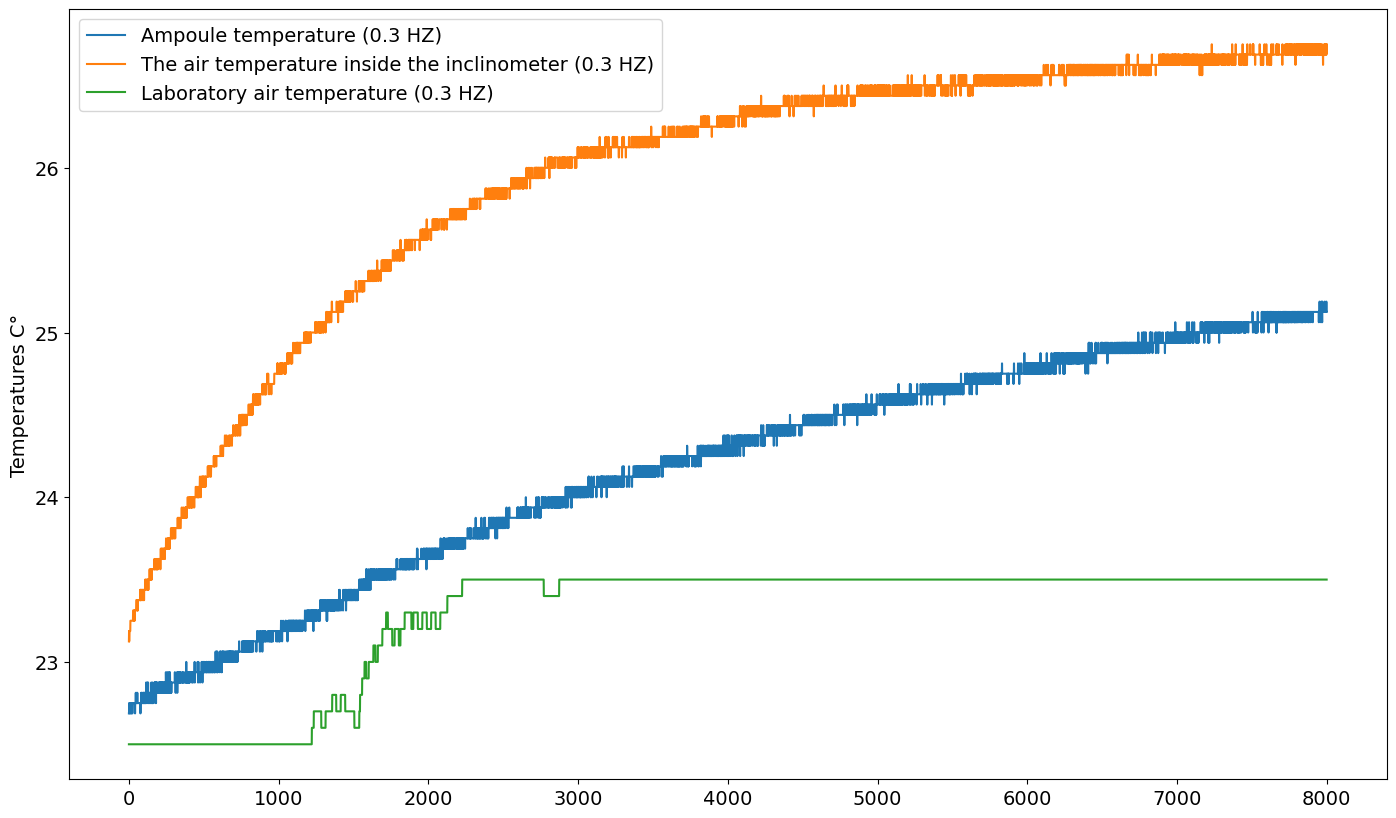

In [1458]:
fig,ax = plt.subplots(figsize=(17,10))
plt.rc('font', size=14)          
lns1=ax.plot(train.index,train[['temperature','air_temp', 'nivel_t']])

ax.set_ylabel('Temperatures С°', fontsize=14)

ax.legend(lns1,['Ampoule temperature (0.3 HZ)',
                'The air temperature inside the inclinometer (0.3 HZ)',
                'Laboratory air temperature (0.3 HZ)'],fontsize=14)

plt.show()

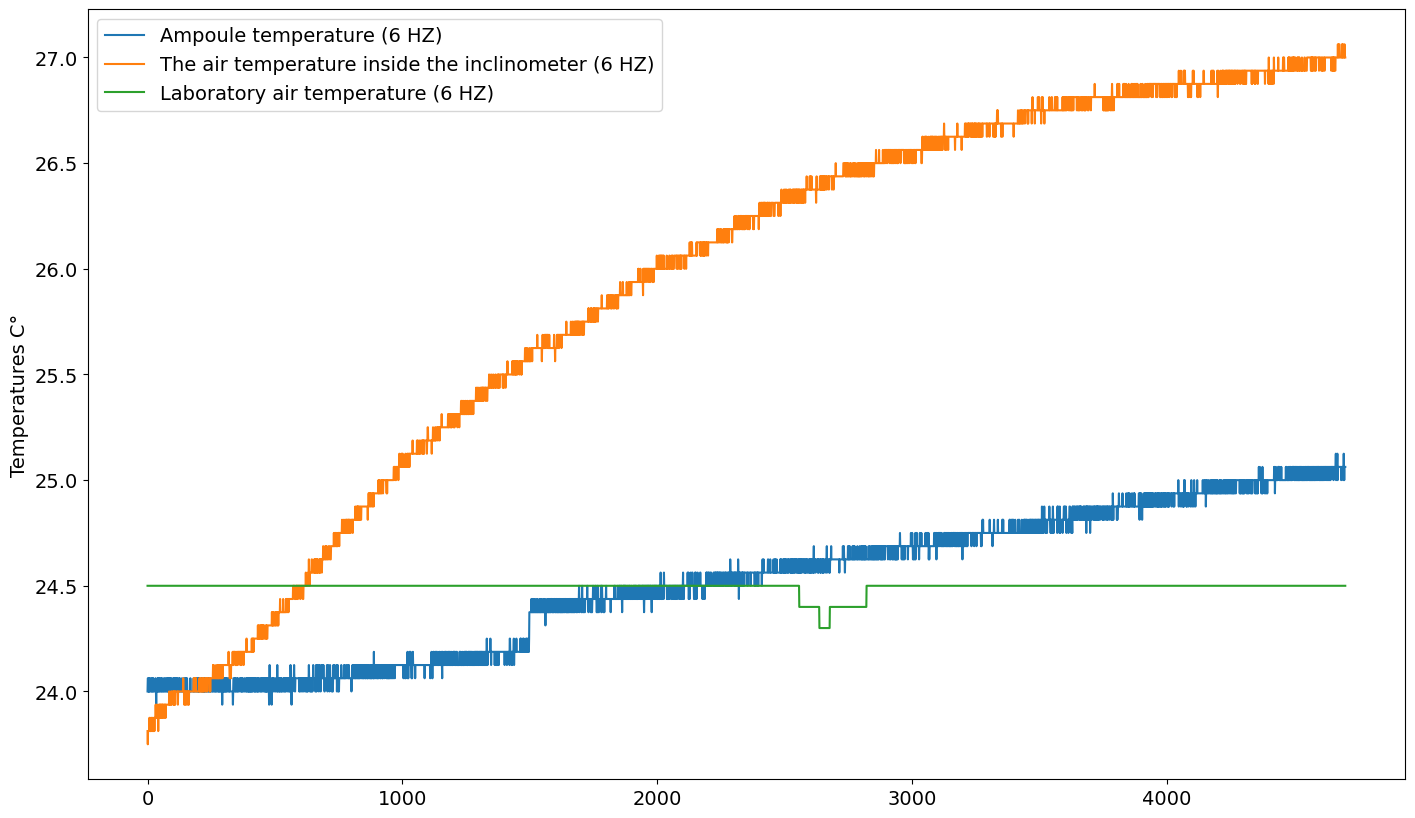

In [1459]:
fig,ax = plt.subplots(figsize=(17,10))
plt.rc('font', size=14)          
lns1=ax.plot(test.index,test[['temperature','air_temp', 'nivel_t']])

ax.set_ylabel('Temperatures С°', fontsize=14)

ax.legend(lns1,['Ampoule temperature (6 HZ)',
                'The air temperature inside the inclinometer (6 HZ)',
                'Laboratory air temperature (6 HZ)'],fontsize=14)

plt.show()

<Axes: >

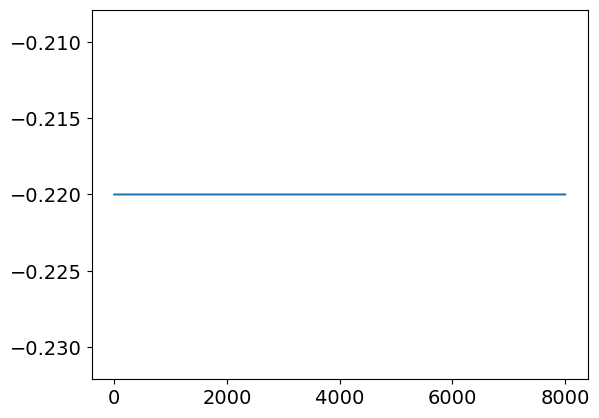

In [1460]:
train[CFG.TARGET].plot()

<Axes: >

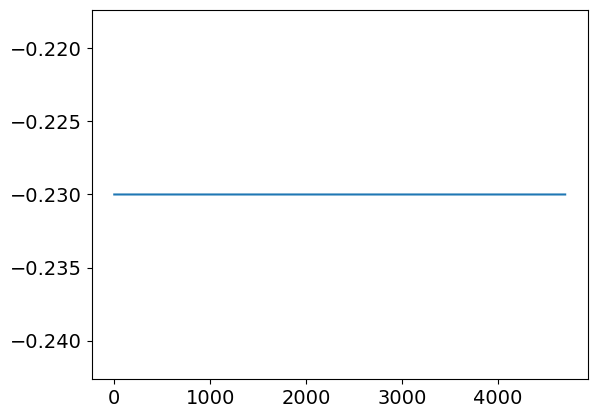

In [1461]:
test[CFG.TARGET].plot()

In [1462]:
train = train.loc[(train['watch_indicator'] != 'False') &
                (train['watch_indicator'] != 'None')]
train = train.drop(columns=['time', 'watch_indicator', 'nivel_t', 'nivel_x'])

test = test.loc[(test['watch_indicator'] != 'False') &
                (test['watch_indicator'] != 'None')]
test = test.drop(columns=['time', 'watch_indicator', 'nivel_t', 'nivel_x'])


In [1463]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)


train['center_bubbles_px'] = train['center_bubbles_px'].loc[(train['center_bubbles_px'] > -5) & (train['center_bubbles_px'] < 10)]
test['center_bubbles_px'] = test['center_bubbles_px'].loc[(test['center_bubbles_px'] > -5) & (test['center_bubbles_px'] < 10)]

# for i in train.columns:
#     if i not in [CFG.TARGET, 'temperature', 'air_temp','center_bubbles_px']:
#         train[i] = train[i].loc[(train[i] > -train[i]*.01) & (train[i] < train[i]*.05)]
#         test[i] = test[i].loc[(test[i] > -test[i]*.01) & (test[i] < test[i]*.05)]

for i in train.columns:
    if i not in [CFG.TARGET, 'temperature', 'air_temp']:
        train[i] = train[i].interpolate(method='nearest', limit_direction='forward')
        test[i] = test[i].interpolate(method='nearest', limit_direction='forward')

In [1464]:
# def agg_features(df, suffix=''):
#     X = pd.DataFrame()    
#     X[suffix+"median"] = df.median(axis=1)
#     X[suffix+"mean"] = df.mean(axis=1)
#     X[suffix+"std"] = df.std(axis=1)
#     X[suffix+"max"] = df.max(axis=1)
#     X[suffix+"min"] = df.min(axis=1)
#     X["length"] = np.sqrt(df['1']**2 - df['center_bubbles_px']**2)
#     return X

In [1465]:
# train = train.join(agg_features(train), how='left')
# test = test.join(agg_features(test), how='left')

In [1466]:
# STEP = 35

# for i in train.columns:
#     # if i not in [CFG.TARGET, 'temperature']:
#     if i not in [CFG.TARGET, 'temperature', 'air_temp']:
#         train[i] = train[i].rolling(STEP).median()
#         train[i] = train[i][STEP:]
#         test[i] = test[i].rolling(STEP).median()
#         test[i] = test[i][STEP:]

In [1467]:

# train = train.fillna(0.0)
# test = test.fillna(0.0)
train.dropna(inplace=True)
test.dropna(inplace=True)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)



columns = ['center_bubbles_px', 'temperature', 'air_temp', CFG.TARGET]

train = train[columns]
test = test[columns]

features = train.drop([CFG.TARGET], axis=1)
target = train[CFG.TARGET]

<Axes: >

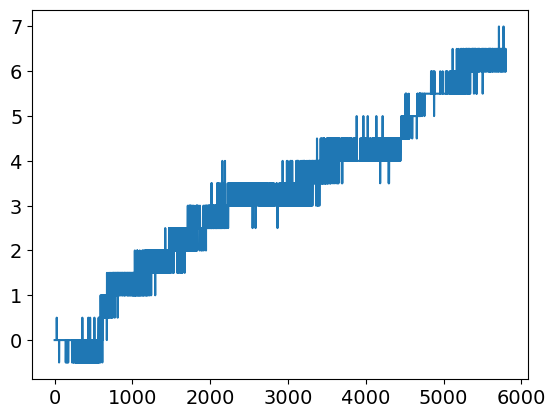

In [1468]:
features['center_bubbles_px'].plot()

# Linear Regression for Ct

slope (95%): -1.641153 +/- 0.083808
intercept (95%): 48.761657 +/- 2.097056


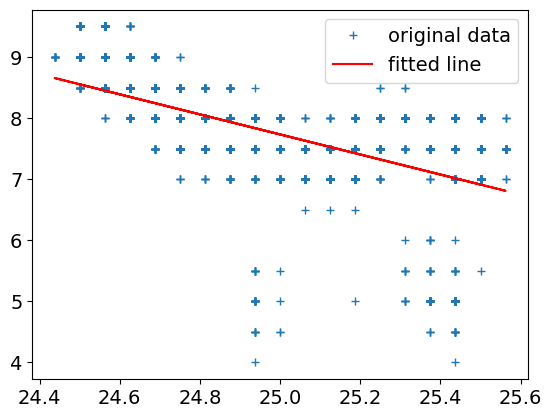

In [1445]:
from scipy import stats

res = stats.linregress(features['temperature'], features['center_bubbles_px'])

from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df))

ts = tinv(0.05, len(features['temperature'])-2)
print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")

print(f"intercept (95%): {res.intercept:.6f}"
      f" +/- {ts*res.intercept_stderr:.6f}")
# print(f"fitted {res.intercept + res.slope*features['temperature']}")
plt.plot(features['temperature'], features['center_bubbles_px'], '+', label='original data')
plt.plot(features['temperature'], res.intercept + res.slope*features['temperature'], 'r', label='fitted line')
plt.legend()
plt.show()

In [1446]:
df_cf = train.copy()

for i in df_cf.columns:
    if i not in [CFG.TARGET, 'temperature', 'air_temp']:
        res = stats.linregress(df_cf['temperature'], df_cf[i])
        df_cf[i] -= res.intercept + res.slope*df_cf['temperature']

In [1447]:
df_cf.head()

,center_bubbles_px,temperature,air_temp,nivel_y
0,0.446604,24.5000,24.1250,-0.22
1,0.946604,24.5000,24.1875,-0.22
2,0.549176,24.5625,24.1875,-0.22
3,0.446604,24.5000,24.2500,-0.22
4,0.446604,24.5000,24.1875,-0.22


In [1448]:
features_l = df_cf.drop([CFG.TARGET], axis=1)
target_l = df_cf[CFG.TARGET]

In [1449]:
np.sqrt(mean_squared_error(target_l, features_l['center_bubbles_px']))

0.6985250689956503

In [1450]:
dif_l1 = target_l - (features_l['center_bubbles_px'])
dif_l1.mean()

-0.21130386329866271

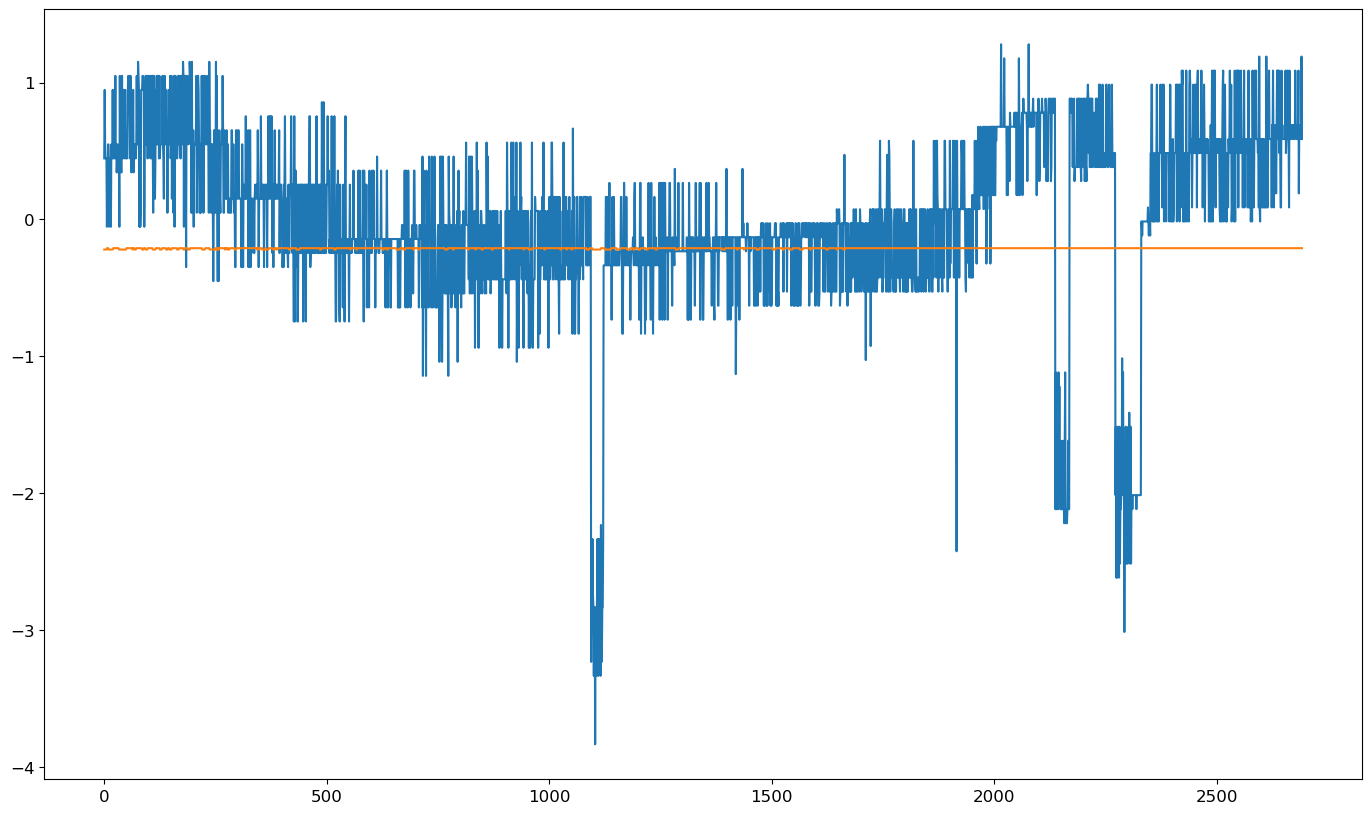

In [1451]:
pd.DataFrame(features_l['center_bubbles_px']).plot(figsize=(17,10),legend=False,fontsize=12);target_l.plot();

<Axes: >

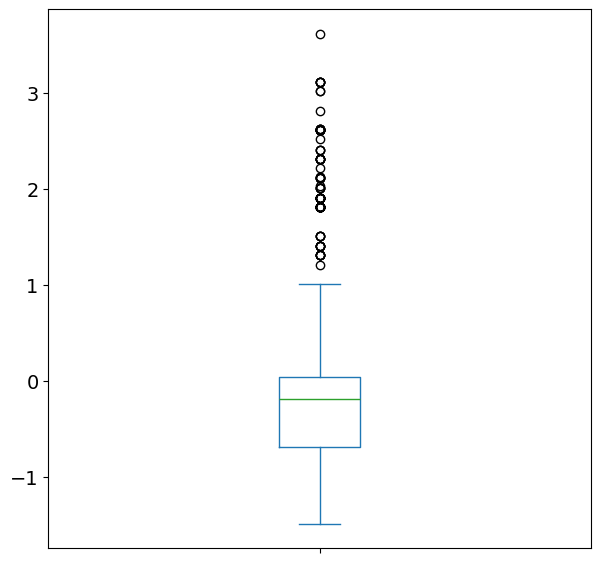

In [1452]:
dif_l1.plot(figsize=(7,7),kind='box')

# Multiple Linear Regression

In [1453]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(features, target)

In [1469]:
pred_l = reg.predict(test.drop(columns=CFG.TARGET))

In [1473]:
np.sqrt(mean_squared_error(test[CFG.TARGET]+.005, pred_l))

0.012283829787643344

In [1474]:
dif_l = test[CFG.TARGET]+.005 - (pred_l)
dif_l.mean()

-0.012164945981071977

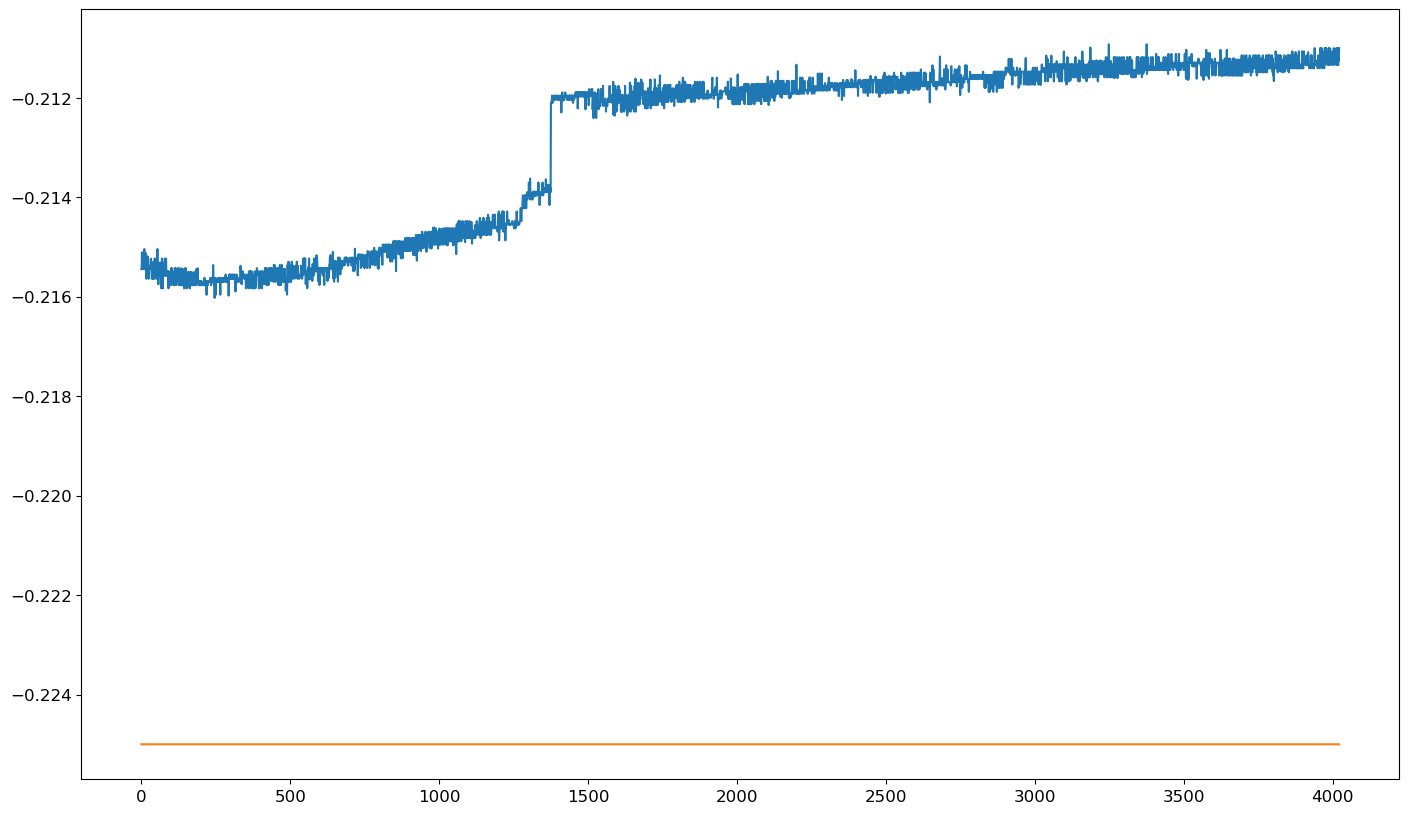

In [1475]:
pd.DataFrame(pred_l).plot(figsize=(17,10),legend=False,fontsize=12);(test[CFG.TARGET]+.005).plot();

<Axes: >

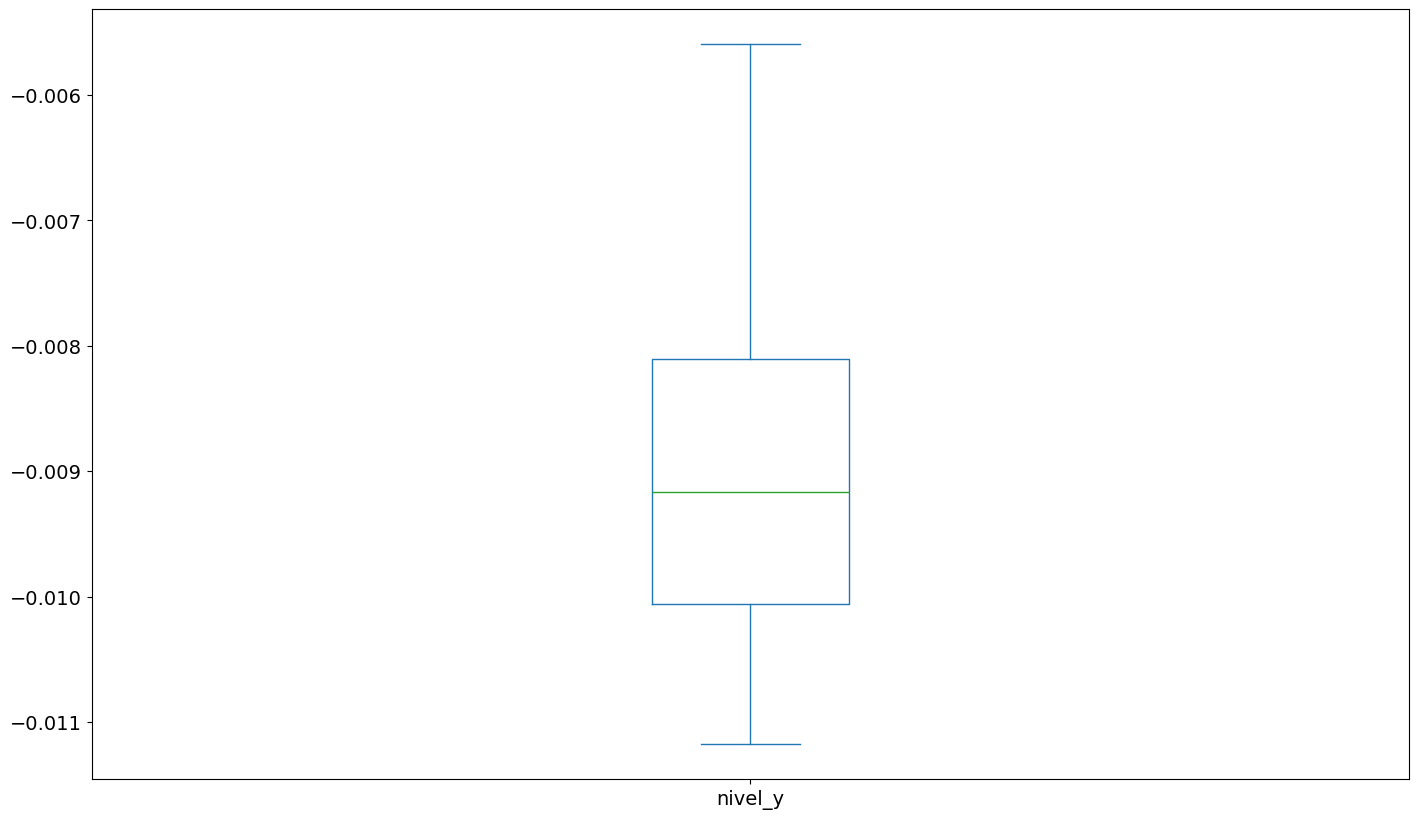

In [1397]:
dif_l.plot(figsize=(17,10),kind='box')

# Cat

In [1398]:
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [1399]:
def build_catboost(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 0.01, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', .1, 1., log=True),
        'random_strength': trial.suggest_float('random_strength', .1, 1., log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', .1, 1., log=True),
        'bootstrap_type':'Bayesian',
        'task_type': 'GPU',
        'loss_function':'RMSE'
    }

    model = CatBoostRegressor(**params, silent=True, random_state=CFG.RANDOM_STATE)
    cv_data = cv(
        Pool(features_train, target_train),
        model.get_params(),
        verbose=False
    )
    return np.min(cv_data['test-RMSE-mean'])

In [1374]:
study = optuna.create_study(direction="minimize")
study.optimize(build_catboost, n_trials=10)

[I 2024-09-16 16:58:23,836] A new study created in memory with name: no-name-5f4862b6-a64a-4375-812b-b820dcbe1821


Training on fold [0/3]
bestTest = 0.2109794825
bestIteration = 999
Training on fold [1/3]
bestTest = 0.2107982935
bestIteration = 999
Training on fold [2/3]


[I 2024-09-16 16:58:46,452] Trial 0 finished with value: 0.21092414127632833 and parameters: {'learning_rate': 1.7569379068437356e-06, 'depth': 6, 'l2_leaf_reg': 0.8091147844286443, 'random_strength': 0.30091581379352567, 'bagging_temperature': 0.12655945680181827}. Best is trial 0 with value: 0.21092414127632833.


bestTest = 0.2109946478
bestIteration = 999
Training on fold [0/3]
bestTest = 0.2027992971
bestIteration = 999
Training on fold [1/3]
bestTest = 0.2026215424
bestIteration = 999
Training on fold [2/3]


[W 2024-09-16 16:59:06,952] Trial 1 failed with parameters: {'learning_rate': 4.136920106551049e-05, 'depth': 4, 'l2_leaf_reg': 0.49985049480116694, 'random_strength': 0.35728247586688505, 'bagging_temperature': 0.6189625226334151} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\DS\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\DS\AppData\Local\Temp\ipykernel_13676\2575964087.py", line 14, in build_catboost
    cv_data = cv(
  File "c:\ProgramData\anaconda3\envs\DS\lib\site-packages\catboost\core.py", line 6924, in cv
    return _cv(
  File "_catboost.pyx", line 5696, in _catboost._cv
  File "_catboost.pyx", line 5728, in _catboost._cv
KeyboardInterrupt
[W 2024-09-16 16:59:06,954] Trial 1 failed with value None.


KeyboardInterrupt: 

In [1167]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.007561668885759355, 'depth': 6, 'l2_leaf_reg': 0.46988217255163506, 'random_strength': 0.3164058982154978, 'bagging_temperature': 0.30867507794164006}
Best RMSE: 0.0037292071625019303


# CB
- Best hyperparameters: {'learning_rate': 0.00047203914766012094, 'depth': 7, 'l2_leaf_reg': 0.12405167415915808, 'random_strength': 0.6117918596087812, 'bagging_temperature': 0.11075605640527406}
- Best RMSE: 0.13195979643689015

# NON-CB
- Best hyperparameters: {'learning_rate': 0.008681151630685426, 'depth': 1, 'l2_leaf_reg': 0.3978744610671192, 'random_strength': 0.32718187893217754, 'bagging_temperature': 0.337077824517019}
- Best RMSE: 0.003096857994992059

In [1400]:
rmses = []
preds = []
skf = KFold(n_splits=CFG.N_FOLDS)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train[CFG.TARGET])):
    print(f'### Fold {fold+1} Training ###')

    X_train = train.loc[train_idx, [c for c in train.columns if c not in [CFG.TARGET]]]
    y_train = train.loc[train_idx, CFG.TARGET]
    X_valid = train.loc[valid_idx, X_train.columns]
    y_valid = train.loc[valid_idx, CFG.TARGET]
    X_test = test[X_train.columns]



    X_train_pool = Pool(X_train, y_train)
    X_valid_pool = Pool(X_valid, y_valid)
    X_test_pool = Pool(X_test)


    model = CatBoostRegressor(
        loss_function='RMSE',
        learning_rate=0.007561668885759355,
        iterations=10000,
        depth=6,
        l2_leaf_reg=0.46988217255163506,
        random_strength=0.3164058982154978,
        bagging_temperature=0.30867507794164006,
        bootstrap_type='Bayesian',
        task_type='GPU',
        random_seed=CFG.RANDOM_STATE,
        verbose=False
    )

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=500, early_stopping_rounds=200)

    pred_valid = model.predict(X_valid_pool)
    preds.append(model.predict(X_test_pool))

    rmse = mean_squared_error(y_valid, pred_valid)**.5
    rmses.append(rmse)
    
    del X_train, y_train, X_valid, y_valid, X_test
    gc.collect()

    print(f'Fold {fold+1} RMSE: {rmse:.5f}\n')

print(f'\nOverall RMSE: {np.median(rmse):.5f} +/- {np.std(rmse):.5f}')

### Fold 1 Training ###
0:	learn: 0.0031773	test: 0.0059108	best: 0.0059108 (0)	total: 29.9ms	remaining: 4m 58s
500:	learn: 0.0028941	test: 0.0050835	best: 0.0050835 (499)	total: 4.95s	remaining: 1m 33s
1000:	learn: 0.0028769	test: 0.0050665	best: 0.0050663 (961)	total: 9.5s	remaining: 1m 25s
bestTest = 0.005065702802
bestIteration = 1064
Shrink model to first 1065 iterations.
Fold 1 RMSE: 0.00507

### Fold 2 Training ###
0:	learn: 0.0032375	test: 0.0052234	best: 0.0052234 (0)	total: 9.78ms	remaining: 1m 37s
500:	learn: 0.0029185	test: 0.0047613	best: 0.0047613 (500)	total: 4.92s	remaining: 1m 33s
1000:	learn: 0.0029117	test: 0.0047548	best: 0.0047548 (998)	total: 9.25s	remaining: 1m 23s
1500:	learn: 0.0029107	test: 0.0047508	best: 0.0047508 (1491)	total: 13.4s	remaining: 1m 16s
2000:	learn: 0.0029095	test: 0.0047495	best: 0.0047495 (2000)	total: 17.7s	remaining: 1m 10s
2500:	learn: 0.0029063	test: 0.0047493	best: 0.0047493 (2474)	total: 22.2s	remaining: 1m 6s
3000:	learn: 0.0029023	te

In [1401]:
model.save_model('model_temp_stable')

In [1402]:
# model = CatBoostRegressor()
# model.load_model('model_temp_stable')

In [1403]:
pd.DataFrame(rmses).median()

0    0.003062
dtype: float64

In [1476]:
r = model.predict(test[train.columns])

In [1477]:
np.sqrt(mean_squared_error(test[CFG.TARGET]+.005, r))

0.013541966048083432

In [1478]:
dif = test[CFG.TARGET]+.005 - (r)
dif.mean()

-0.013516843312494559

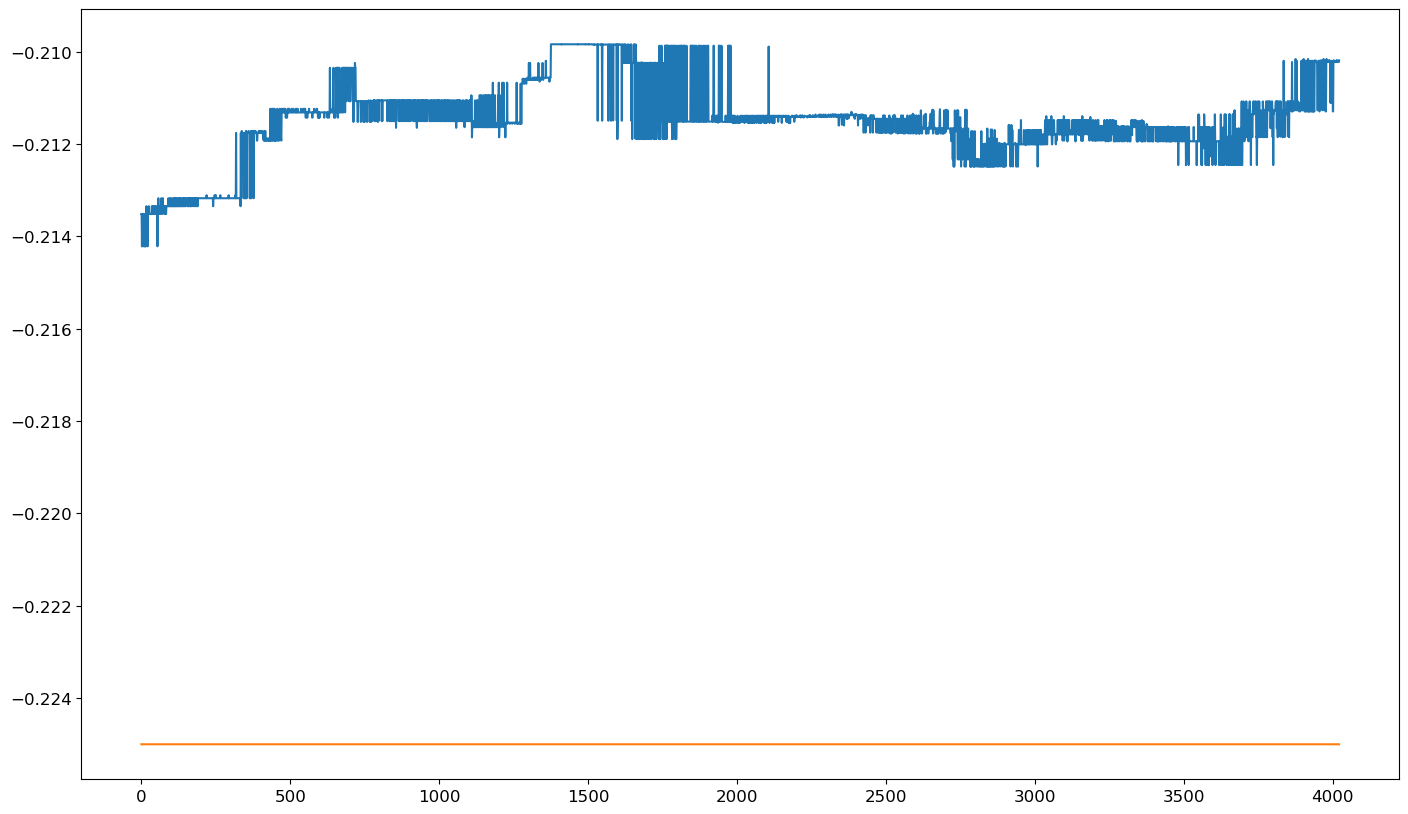

In [1480]:
pd.DataFrame(r).plot(figsize=(17,10),legend=False,fontsize=12);(test[CFG.TARGET]+.005).plot();

<Axes: >

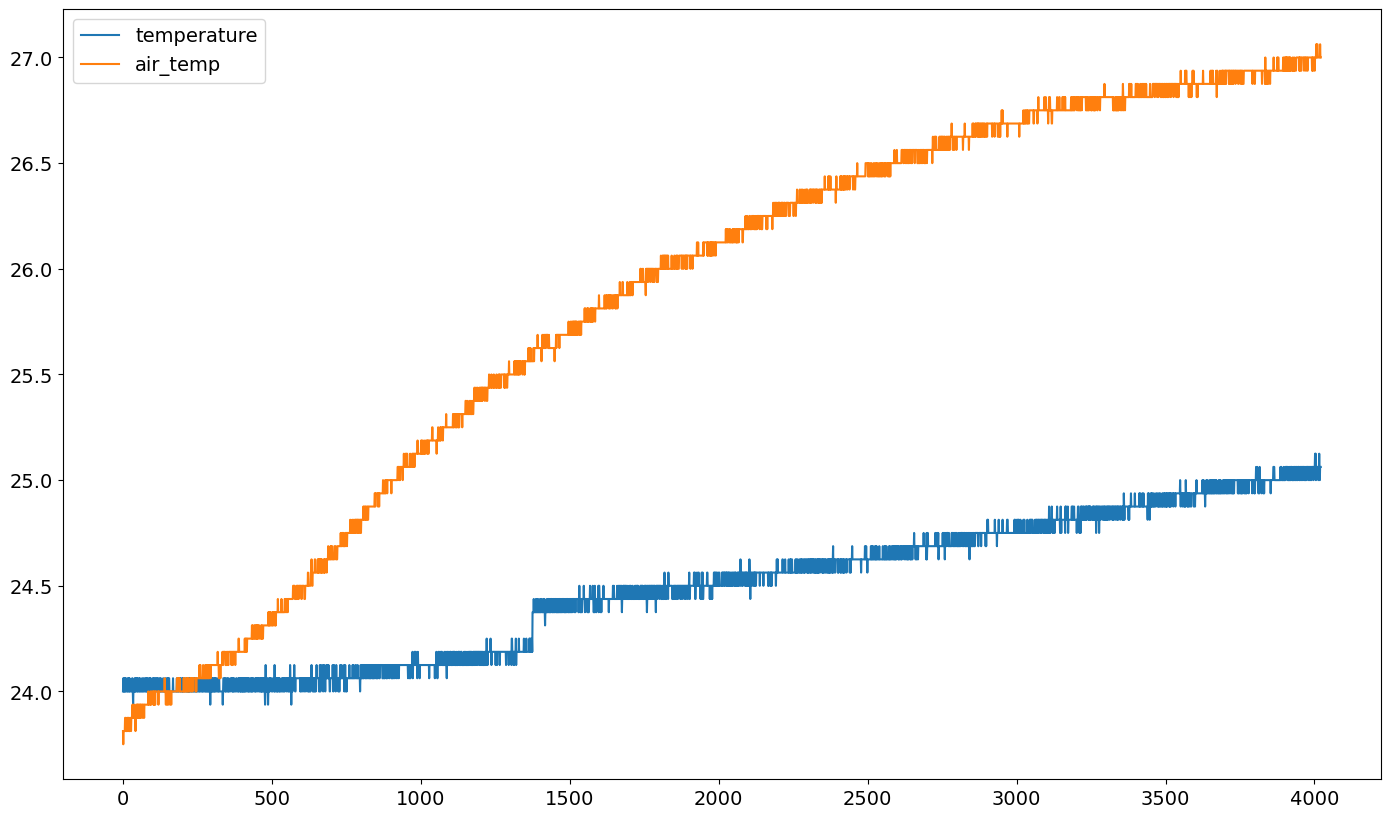

In [1481]:
test['temperature'].plot(legend=True,figsize=(17,10));test['air_temp'].plot(legend=True)

<Axes: >

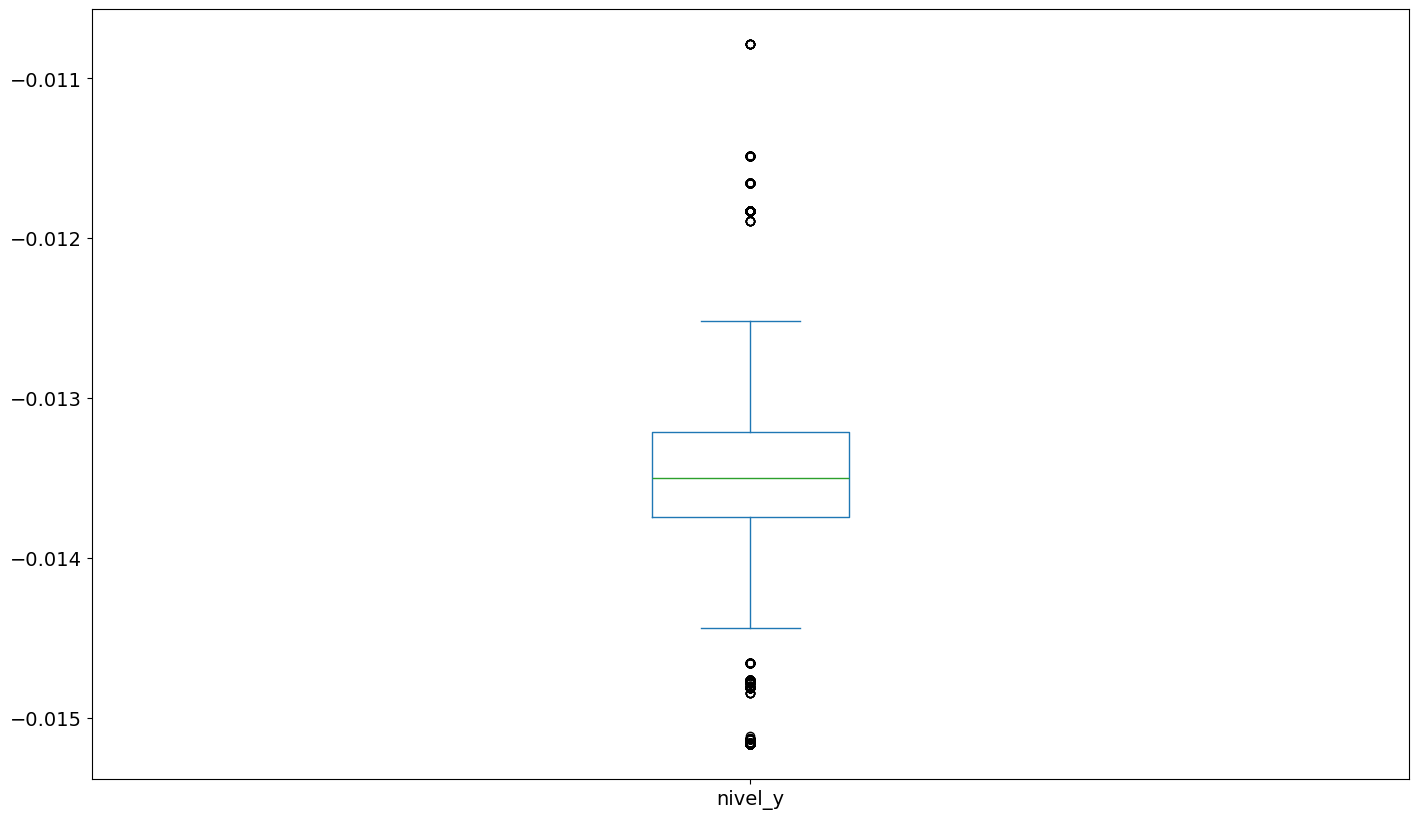

In [1482]:
dif.plot(figsize=(17,10),kind='box')

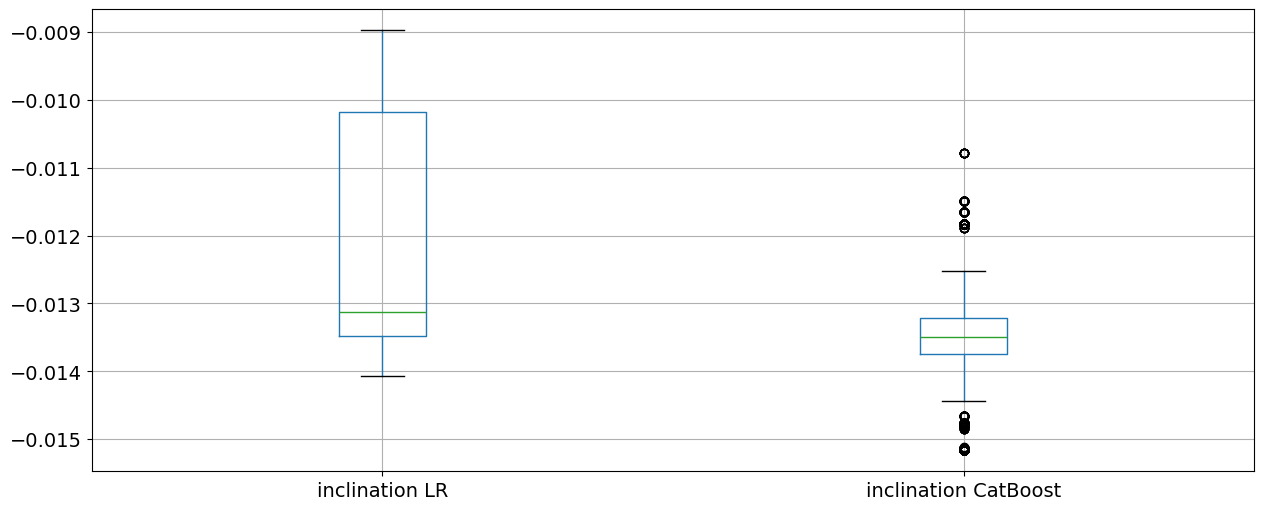

In [1483]:
LR = pd.DataFrame({'inclination LR' : dif_l, 
        'inclination CatBoost' : dif,})

fig = plt.figure(figsize=(15,6))
ax1 =fig.add_subplot(1,1,1)
LR.boxplot(ax = ax1)
plt.show()

# NN

In [1038]:
features

,center_bubbles_px,temperature,1,2,3,4,5,6,7,8,...,92,93,94,95,96,97,98,99,100,air_temp
0,9.0,24.5000,-173.0,-173.0,-172.0,-172.0,-171.0,-170.0,-170.0,-169.0,...,42.0,46.0,47.0,57.0,58.0,73.0,73.0,74.0,74.0,24.1250
1,9.5,24.5000,-172.0,-172.0,-171.0,-171.0,-170.0,-170.0,-169.0,-167.0,...,39.0,41.0,42.0,47.0,48.0,57.0,58.0,64.0,65.0,24.1875
2,9.0,24.5625,-173.0,-173.0,-172.0,-172.0,-171.0,-170.0,-169.0,-167.0,...,82.0,89.0,90.0,102.0,103.0,109.0,110.0,113.0,114.0,24.1875
3,9.0,24.5000,-173.0,-173.0,-172.0,-172.0,-171.0,-171.0,-170.0,-170.0,...,10.0,25.0,26.0,41.0,42.0,45.0,46.0,57.0,58.0,24.2500
4,9.0,24.5000,-173.0,-173.0,-172.0,-172.0,-172.0,-172.0,-170.0,-166.0,...,42.0,46.0,47.0,49.0,50.0,52.0,53.0,55.0,56.0,24.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,7.5,25.5625,-173.0,-173.0,-172.0,-172.0,-171.0,-171.0,-171.0,-166.0,...,95.0,104.0,105.0,105.0,106.0,111.0,112.0,116.0,117.0,27.3750
2688,7.5,25.5625,-173.0,-173.0,-172.0,-172.0,-171.0,-170.0,-167.0,-166.0,...,80.0,81.0,91.0,92.0,105.0,106.0,111.0,112.0,113.0,27.3750
2689,7.5,25.5000,-173.0,-173.0,-172.0,-172.0,-172.0,-172.0,-171.0,-170.0,...,81.0,82.0,93.0,94.0,105.0,105.0,106.0,106.0,111.0,27.3750
2690,8.0,25.5625,-173.0,-173.0,-172.0,-172.0,-171.0,-169.0,-168.0,-166.0,...,57.0,73.0,74.0,81.0,82.0,93.0,94.0,105.0,105.0,27.3750


In [1068]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [1040]:
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [1041]:
def build_model():
    model_nn = Sequential()
    model_nn.add(Dense(32, activation='tanh'))
    model_nn.add(Dense(1))
    model_nn.compile(optimizer=Adam(), 
                    loss='mean_squared_error', 
                    metrics=[RootMeanSquaredError()])
    return model_nn

In [1042]:
model_nn = build_model()

model_nn.fit(
    features_train,
    target_train,
    epochs=100
)

Epoch 1/100
64/64 [==============================] - 0s 699us/step - loss: 0.0069 - root_mean_squared_error: 0.0832
Epoch 2/100
64/64 [==============================] - 0s 669us/step - loss: 4.6484e-04 - root_mean_squared_error: 0.0216
Epoch 3/100
64/64 [==============================] - 0s 504us/step - loss: 3.2283e-04 - root_mean_squared_error: 0.0180
Epoch 4/100
64/64 [==============================] - 0s 508us/step - loss: 2.8001e-04 - root_mean_squared_error: 0.0167
Epoch 5/100
64/64 [==============================] - 0s 499us/step - loss: 2.6454e-04 - root_mean_squared_error: 0.0163
Epoch 6/100
64/64 [==============================] - 0s 508us/step - loss: 2.1917e-04 - root_mean_squared_error: 0.0148
Epoch 7/100
64/64 [==============================] - 0s 492us/step - loss: 1.9850e-04 - root_mean_squared_error: 0.0141
Epoch 8/100
64/64 [==============================] - 0s 508us/step - loss: 2.0121e-04 - root_mean_squared_error: 0.0142
Epoch 9/100
64/64 [=========================

In [1116]:
def build_neural_network(hp):    
    model = Sequential()
    model.add(layers.Flatten())
    for i in range(hp.Int("num_layers", 1, 8)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=128, max_value=1024, step=64),
                # activation=hp.Choice("activation", ["sigmoid"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.35))
    model.add(layers.Dense(1))
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=[RootMeanSquaredError()]
    )
    return model

In [1117]:
build_neural_network(keras_tuner.HyperParameters())

In [1118]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_neural_network,
    objective=keras_tuner.Objective('val_root_mean_squared_error', 'min'),
    max_trials=5,
    executions_per_trial=3,
    overwrite=True,
)

In [1119]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [1120]:
X_train, X_val, y_train, y_val = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [1121]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Trial 5 Complete [00h 00m 53s]
val_root_mean_squared_error: 0.003726404548312227

Best val_root_mean_squared_error So Far: 0.0033492662478238344
Total elapsed time: 00h 04m 01s


In [1122]:
best_NN = build_neural_network(tuner.get_best_hyperparameters()[0])

In [1123]:
callback = EarlyStopping(monitor='loss', patience=100)

In [1124]:
best_NN.fit(
    X_train,  
    y_train,
    epochs=10000,
    callbacks=[callback]
)

Epoch 1/10000
64/64 [==============================] - 0s 3ms/step - loss: 0.0442 - root_mean_squared_error: 0.2102
Epoch 2/10000
64/64 [==============================] - 0s 3ms/step - loss: 2.5303e-04 - root_mean_squared_error: 0.0159
Epoch 3/10000
64/64 [==============================] - 0s 3ms/step - loss: 1.1717e-04 - root_mean_squared_error: 0.0108
Epoch 4/10000
64/64 [==============================] - 0s 3ms/step - loss: 7.2409e-05 - root_mean_squared_error: 0.0085
Epoch 5/10000
64/64 [==============================] - 0s 3ms/step - loss: 4.9917e-05 - root_mean_squared_error: 0.0071
Epoch 6/10000
64/64 [==============================] - 0s 3ms/step - loss: 4.3473e-05 - root_mean_squared_error: 0.0066
Epoch 7/10000
64/64 [==============================] - 0s 3ms/step - loss: 4.1249e-05 - root_mean_squared_error: 0.0064
Epoch 8/10000
64/64 [==============================] - 0s 3ms/step - loss: 4.1724e-05 - root_mean_squared_error: 0.0065
Epoch 9/10000
64/64 [=======================

In [1061]:
ynew = best_NN.predict(features)
class_probabilities = np.hstack((1-ynew, ynew))

85/85 [==============================] - 0s 512us/step


In [1109]:
test.drop(columns=CFG.TARGET)

,center_bubbles_px,temperature,1,2,3,4,5,6,7,8,...,92,93,94,95,96,97,98,99,100,air_temp
0,6.5,25.0000,-175.0,-175.0,-174.0,-174.0,-173.0,-172.0,-171.0,-170.0,...,77.0,78.0,95.0,96.0,103.0,104.0,109.0,109.0,110.0,24.7500
1,6.5,24.9375,-175.0,-175.0,-174.0,-174.0,-174.0,-174.0,-172.0,-170.0,...,43.0,55.0,56.0,75.0,76.0,77.0,78.0,93.0,94.0,24.7500
2,6.5,25.0000,-175.0,-175.0,-174.0,-174.0,-173.0,-173.0,-173.0,-172.0,...,34.0,39.0,40.0,41.0,42.0,49.0,50.0,60.0,61.0,24.7500
3,7.0,24.9375,-174.0,-174.0,-172.0,-170.0,-169.0,-168.0,-167.0,-167.0,...,74.0,78.0,79.0,96.0,97.0,104.0,105.0,107.0,108.0,24.6875
4,6.0,24.9375,-176.0,-176.0,-175.0,-175.0,-174.0,-174.0,-174.0,-173.0,...,26.0,33.0,34.0,39.0,40.0,41.0,42.0,57.0,58.0,24.6875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5144,7.5,25.9375,-170.0,-170.0,-168.0,-168.0,-167.0,-167.0,-166.0,-164.0,...,3.0,46.0,47.0,53.0,54.0,57.0,58.0,66.0,67.0,27.2500
5145,8.0,25.9375,-169.0,-169.0,-167.0,-163.0,-162.0,-161.0,-160.0,-160.0,...,90.0,97.0,98.0,106.0,107.0,113.0,114.0,118.0,119.0,27.2500
5146,8.0,25.8750,-170.0,-170.0,-169.0,-169.0,-168.0,-167.0,-164.0,-163.0,...,101.0,102.0,106.0,107.0,113.0,114.0,117.0,117.0,118.0,27.2500
5147,7.5,25.8750,-170.0,-170.0,-169.0,-169.0,-168.0,-167.0,-163.0,-162.0,...,60.0,61.0,65.0,66.0,87.0,88.0,89.0,90.0,101.0,27.2500


In [1110]:
test_nn = scaler.transform(test.drop(columns=CFG.TARGET))

In [1111]:
test_nn

array([[   6.5   ,   25.    , -175.    , ...,  109.    ,  110.    ,
          24.75  ],
       [   6.5   ,   24.9375, -175.    , ...,   93.    ,   94.    ,
          24.75  ],
       [   6.5   ,   25.    , -175.    , ...,   60.    ,   61.    ,
          24.75  ],
       ...,
       [   8.    ,   25.875 , -170.    , ...,  117.    ,  118.    ,
          27.25  ],
       [   7.5   ,   25.875 , -170.    , ...,   90.    ,  101.    ,
          27.25  ],
       [   8.5   ,   25.9375, -169.    , ...,   90.    ,   91.    ,
          27.25  ]])

In [1125]:
ynew = best_NN.predict(test_nn)
class_probabilities = np.hstack((1-ynew, ynew))
pred = pd.DataFrame(ynew)

161/161 [==============================] - 0s 1ms/step


In [1126]:
np.sqrt(mean_squared_error(test[CFG.TARGET], pred))

6.825533513961069

In [1127]:
dif = test[CFG.TARGET] - pred
dif[0].mean()

-6.769303756220453

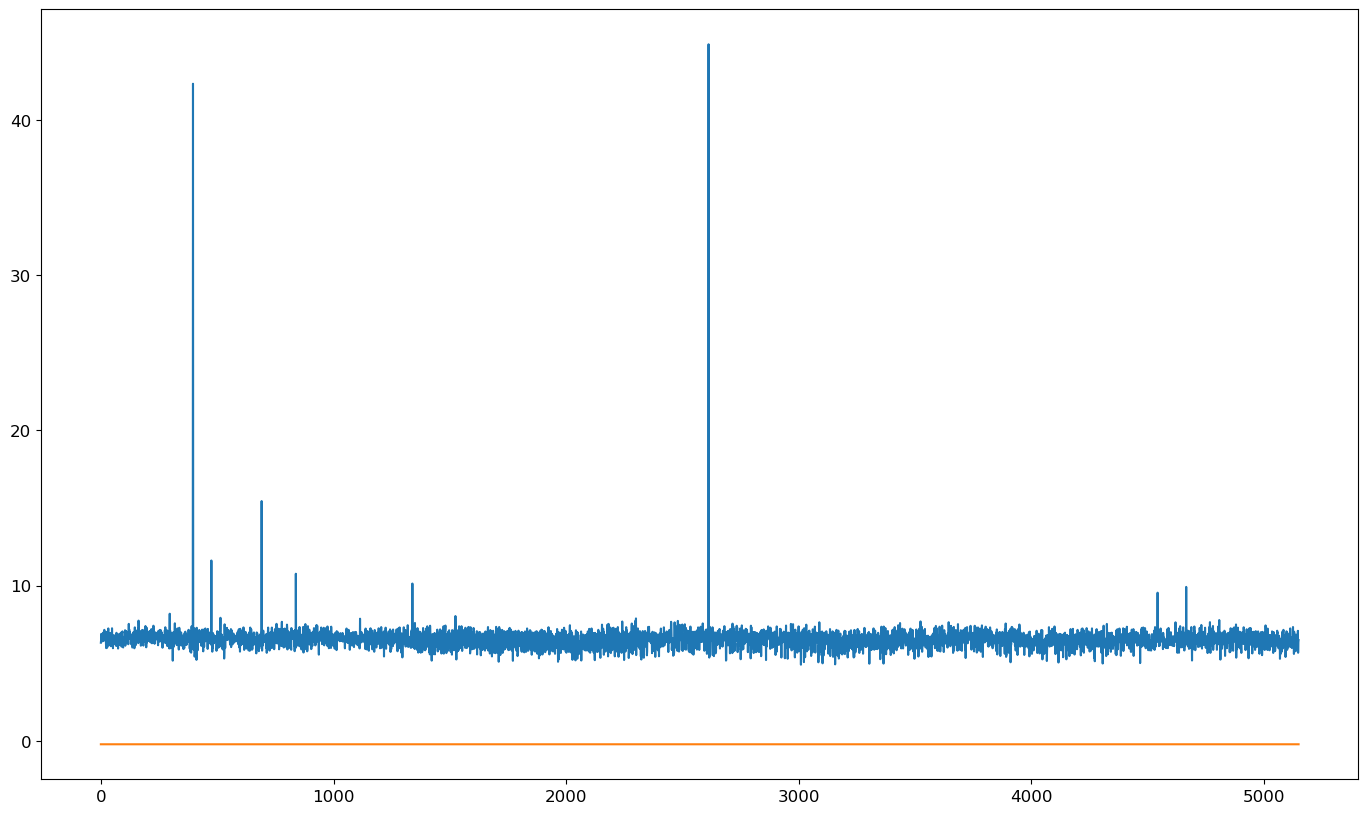

In [1128]:
pd.DataFrame(pred).plot(figsize=(17,10),legend=False,fontsize=12);(test[CFG.TARGET]).plot();

In [1055]:
np.sqrt(mean_squared_error(target, pred))

0.003303054149798358

<Axes: >

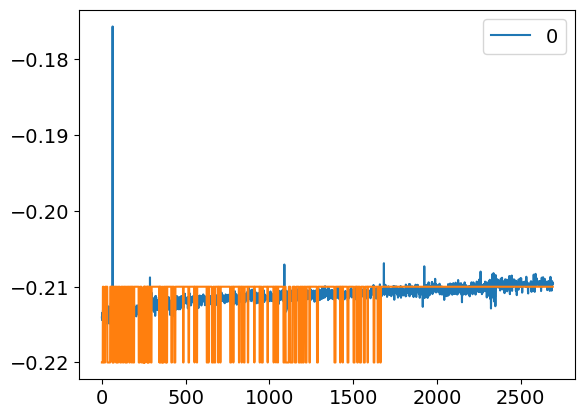

In [1056]:
pred.plot(); target.plot()

In [1057]:
dif = target - pred[0]

In [1058]:
dif.std()

0.0032988872153214143

In [1059]:
dif.mean()

-0.0001776300897658425

# Test NN

In [198]:
test_df = pd.read_csv('./test/test1.csv')

In [199]:
test_df = test_df.loc[(test_df['watch_indicator'] != 'False') &
(test_df['watch_indicator'] != 'None')]
test_df = test_df.drop(columns=['time', 'watch_indicator', 'nivel_t', 'nivel_x'])

In [200]:
test_df = test_df.reset_index(drop=True)
for i in test_df.columns:
    if i not in [CFG.TARGET, 'temperature']:
        test_df[i] = test_df[i].interpolate()

In [201]:
test_df = test_df.join(agg_features(test_df), how='left')

In [202]:
for i in test_df.columns:
    if i not in [CFG.TARGET, 'temperature']:
        print(i)
        test_df[i] = test_df[i].rolling(5).median()
        test_df[i].fillna(0, inplace=True)

center_bubbles_px
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
median
mean
std
max
min


In [203]:
features = test_df.drop([CFG.TARGET],axis=1)
target = test_df[CFG.TARGET]

In [204]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [205]:
pred = best_NN.predict(features)

19/19 [==============================] - 0s 833us/step


In [206]:
pred = pd.DataFrame(pred)

In [207]:
np.sqrt(mean_squared_error(target, pred))

0.3847204189031395

<Axes: >

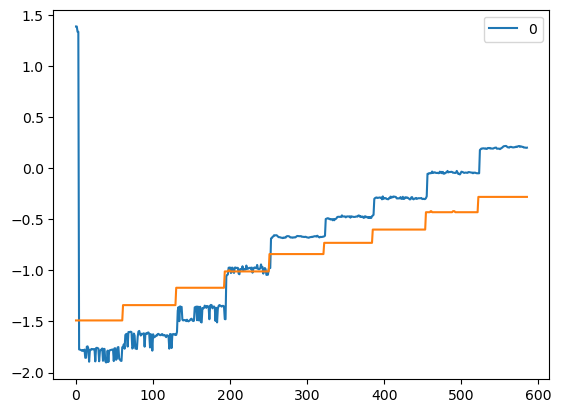

In [208]:
pd.DataFrame(pred).plot();target.plot()